# **Практика**

*К нам пришёл заказчик, которому необходимо проанализировать клиентов торгового центра и выделить разные группы покупателей, чтобы понять, как дальше развивать услуги торгового центра, магазины каких сегментов открывать.*

*В [**файле**](https://lms.skillfactory.ru/assets/courseware/v1/f60995f3c75188d00b1c97483dd0037d/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/segmented_customers.zip) содержится основная информация о покупателе: идентификатор, возраст, пол, доход, индекс расходов. Индекс расходов считается на основе таких параметров, как поведение клиента и данные о покупках, и принимает значение от 1 до 100.*

В ходе работы мы подготовим датасет, попробуем несколько видов кластеризации и оценим её качество.

Начнём с просмотра датасета:

In [36]:
# импортируем библиотеки для работы с данными
import pandas as pd
from sklearn import preprocessing 
import seaborn as sns
import plotly
import plotly.express as px
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

# импортируем DBSCAN-кластеризацию
from sklearn.cluster import DBSCAN
# импортируем алгомеративную кластеризацию из sklearn
from sklearn.cluster import AgglomerativeClustering
# импортируем метрику силуэта
from sklearn.metrics import silhouette_score


In [42]:
# загрузим данные
df = pd.read_csv("data/segmented_customers.csv")
# посмотрим на данные
df.head()

,customer_id,gender,age,annual_income,spending_score,cluster
0,1,1,19.0,15.0,39.0,3
1,2,1,21.0,15.0,81.0,4
2,3,0,20.0,16.0,6.0,3
3,4,0,23.0,16.0,77.0,4
4,5,0,31.0,17.0,40.0,3


In [5]:
# посмотрим, есть ли пропуски в датасете
df[df.isna().any(axis=1)]

,customer_id,gender,age,annual_income,spending_score


In [ ]:
# пропусков не так много, поэтому мы можем удалить данные с пропусками
df = df.dropna()

# переименуем столбцы для более удобной работы
df.rename(columns = {'CustomerID' : 'customer_id', 'Gender' : 'gender', 
                    'Age': 'age', 'Annual Income (k$)': 'annual_income', 
                    'Spending Score (1-100)': 'spending_score', }, inplace = True)

In [6]:
# проверим, есть ли в данных дубликаты
df[df.duplicated(subset=['customer_id'])]

,customer_id,gender,age,annual_income,spending_score


Чтобы мы могли визуально оценивать результаты кластеризации, будем проводить её по трём признакам, а именно: годовой заработок, коэффициент покупательской способности и возраст. Визуализируем распределение данных:

In [8]:
# передаём датафрейм и поля, которые нужно использовать для осей абсцисс, ординат и аппликат
fig = px.scatter_3d(
    data_frame=df, 
    x = 'age', 
    y = 'annual_income', 
    z = 'spending_score', 
    width=1000,
    height=700
)

#отображаем график
fig.show()

Так как нам часто будет требоваться визуализировать результаты кластеризации, напишем для этого функцию. Она будет принимать датафрейм и название столбца датафрейма с результатами кластеризации. Так как нас будут стабильно интересовать три столбца (age, annual_income, spending_score), зафиксируем их названия внутри функции:

In [41]:
def get_3d_visualization(df, clust_res):
    fig = px.scatter_3d(
        data_frame=df, 
        x = 'age', 
        y = 'annual_income', 
        z = 'spending_score', 
        color = clust_res,
        width=1000,
        height=700
    )

    #возвращаем график
    return fig

In [10]:
# Сохраним признаки, по которым будем проводить моделирование, в переменную X:

X = df[['age', 'annual_income', 'spending_score']]

Как мы видим, данные разрежённые и неоднородные, а значит, применять DBSCAN будет сложно, нужно будет подбирать параметры для кластеризации.

## **ЗАДАЧИ**

In [14]:
# Попробуйте провести DBSCAN-кластеризацию со значениями по умолчанию. Сколько кластеров у вас получилось?

#запускаем кластеризацию на наших данных
clustering = DBSCAN().fit_predict(X)

get_3d_visualization(df, clustering)

Алгоритм посчитал всё выбросами.

Как видно, алгоритм плохо работает с настройками по умолчанию, поэтому попробуем изменить их.

Большая часть наших данных разрежённые, а чем больше разброс точек в датасете, тем большее значение радиуса вокруг точки (eps) нужно задавать. Так как данные разрежённые, попробуем увеличить значение eps до 11 и визуально оценим результат:

In [22]:
#запускаем кластеризацию на наших данных
dbscan = DBSCAN(eps=11)
clustering_dbscan_res = dbscan.fit_predict(X)
df['dbscan_res_eps_11'] = clustering_dbscan_res

get_3d_visualization(df, 'dbscan_res_eps_11')

Много точек, которые должны относиться к кластеру, были размечены как выбросы (синие точки).

Такое происходит потому, что данные неоднородны: в некоторых областях они разряжены, а в других имеют большую плотность. Поэтому данный способ, основанный на плотности, не очень подходит для кластеризации.
***
Проведём агломеративную кластеризацию, чтобы построить дендрограмму и по ней оценить количество кластеров, на которое можно разделить датасет. Напишем функцию, которая будет принимать количество кластеров и матрицу с признаками:

In [24]:
# напишем функцию, которая будет проводить алгомеративную кластеризацию
# на вход она будет принимать X — матрицу с признаками для кластеризации и n_clusters — количество кластеров,
# на выходе будет возвращать список с номерами кластеров
def get_aggl_clustering(X, n_clusters):
    # запустим агломеративную кластеризацию
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    # обучим модель агломеративной кластеризации
    agglomerative_clustering.fit(X)
    # получим список c информацией, к какому кластеру относятся объекты
    aggl_prediction = agglomerative_clustering.labels_
    # вернём список с результатами
    return aggl_prediction

Теперь, вооружившись знаниями из юнита про иерархическую кластеризацию, самостоятельно проведите агломеративную кластеризацию, воспользовавшись функцией, которую мы только что написали. После этого визуализируйте полученную дендрограмму. Количество кластеров для кластеризации укажите равным 3 (на данном этапе это не очень важно).

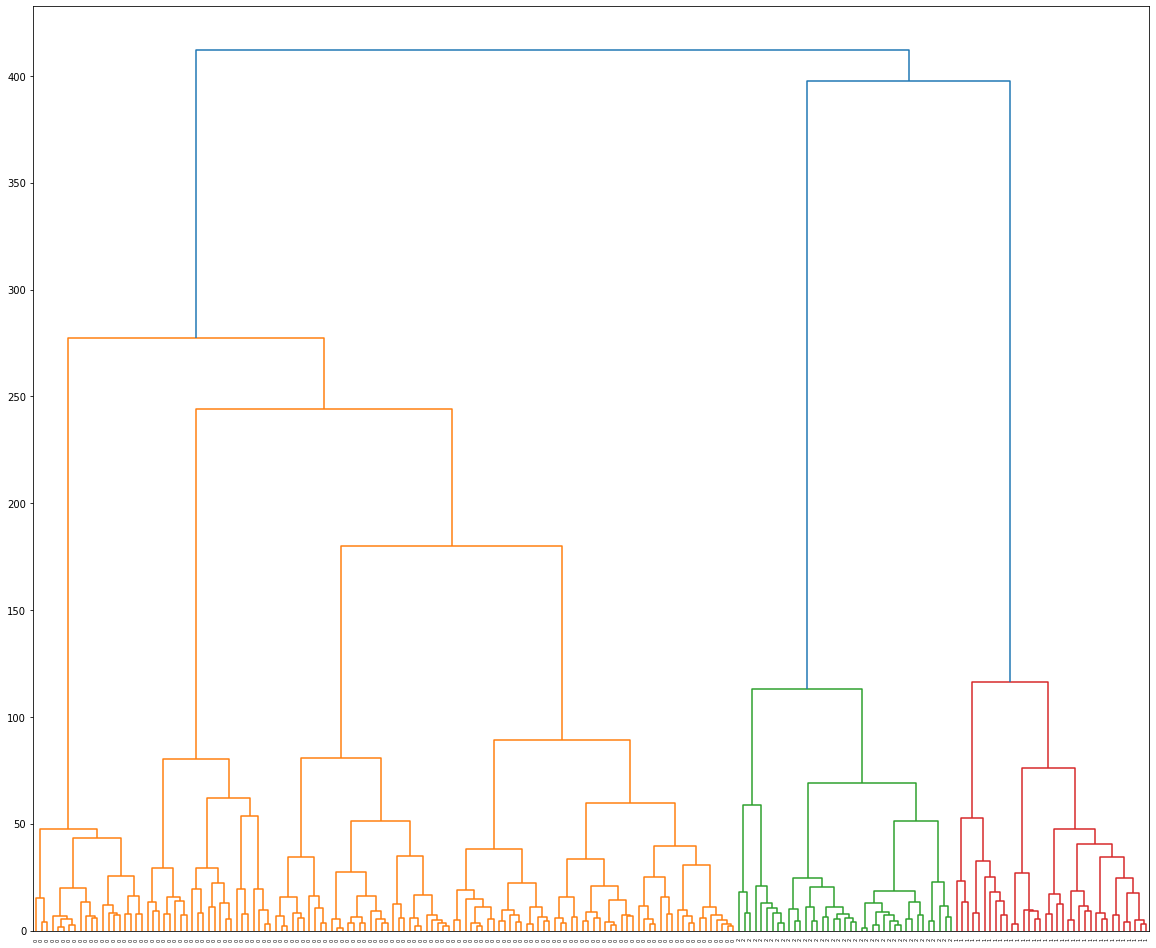

In [29]:
aggl_clustering=get_aggl_clustering(X, 3)

# рассчитаем расстояния между кластерами
linked = linkage(X, 'ward')

plt.figure(figsize=(20, 17))

# визуализируем дендрограмму с ориентацией top
# сначала будут отрисовываться кластеры с минимальным расстоянием между ними
dendrogram(Z=linked,
            orientation='top',
            labels=aggl_clustering,
            distance_sort='descending',
            show_leaf_counts=True)

plt.show()

Как мы можем судить из дендрограммы, если взять евклидово расстояние между кластерами, равное 150, датасет будет делиться на шесть кластеров.

Напомним, что мы проводим воображаемую горизонтальную линию на отметке 150 по оси y. Далее смотрим, сколько веток дендрограммы пересекла данная линия. Наша линия пересекает шесть линий — значит, датасет делится на шесть кластеров.

Давайте визуально оценим, что из этого получилось. Для этого обучим модель агломеративной кластеризации с количеством кластеров, равным 6:

In [44]:
df['aggl_res_6'] = get_aggl_clustering(df[['age', 'annual_income', 'spending_score']], 6)
get_3d_visualization(df, 'aggl_res_6')

Итак, кластеры разделились хорошо.

Теперь давайте воспользуемся коэффициентом силуэта и узнаем оптимальное количество кластеров. Совпадает ли это число с тем, что мы подобрали, используя дендрограмму?

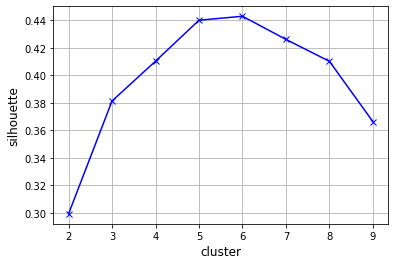

In [39]:
# Для агломеративной кластеризации самостоятельно с помощью
# коэффициента силуэта подберите оптимальное количество кластеров.
# Сколько кластеров у вас получилось?

silhouette = []
for clust_num in range(2, 10):
    silhouette.append(silhouette_score(X, get_aggl_clustering(df[['age', 'annual_income', 'spending_score']], clust_num)))

# визуализируем коэффициенты силуэта для разного количества кластеров
plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.grid()
plt.plot([i for i in range(2, 10)], silhouette, 'xb-')

***
Теперь рассмотрим столбец cluster: в нём есть информация о том, к какому кластеру должен принадлежать каждый объект из датасета. Значит, мы можем проверить качество кластеризации, посчитав различные метрики.

В [**файле**](https://lms.skillfactory.ru/assets/courseware/v1/61111b128cb33c7c0469db3bd279a59d/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/segmented_customers_cluster.zip) содержится основная информация о покупателе со столбцом cluster: идентификатор, возраст, пол, доход, индекс расходов.

Метрику полноты можно вызвать из модуля cluster библиотеки sklearn. Метрика рассчитывается следующим образом:

In [45]:
from sklearn.metrics.cluster import completeness_score

print(completeness_score(labels_true=df.cluster, labels_pred=df.aggl_res_6))

0.9858363091910892


Судя по значению метрики, кластеризация проведена отлично: кластеры получились наполненными элементами, а значит данные результаты можно дальше использовать для анализа.